# In this notebook, we explore **convolutional autoencoders**

[![img](https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)]

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)


datapath = '/content/drive/My Drive/ai-side-projects/3dshapes_autoencoder'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading data: [Shapes 3D](https://github.com/google-deepmind/3d-shapes/tree/master)

 following [their notebook](https://github.com/google-deepmind/3d-shapes/blob/master/3dshapes_loading_example.ipynb)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import tensorflow as tf

try:
    datapath
except:
    datapath = '/Users/sdbykov/My Drive/ai-side-projects/3dshapes_autoencoder'

%matplotlib inline


In [15]:
# load dataset
dataset = h5py.File(datapath+'/3dshapes.h5', 'r')


In [16]:
N_training = 10000

#images = dataset['images'][0:-1]
#np.random.shuffle(images) #takes forever on colab, hence will have to select only first ~10k images. This is probably the cause of all floors being red.

#alternative randomness, also very slow
#rand_idxs = np.random.randint(len(images), size=10000)
#mages = images[rand_idxs]

images = dataset['images'][0:N_training]

images = images/255

image_shape = images.shape[1:]
n_samples = images.shape[0]


In [17]:
ds = tf.data.Dataset.from_tensor_slices((images,images))
ds = ds.shuffle(N_training)


train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)
test_size = int(0.15 * n_samples)


batch_size = 32

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)




## plot data examples

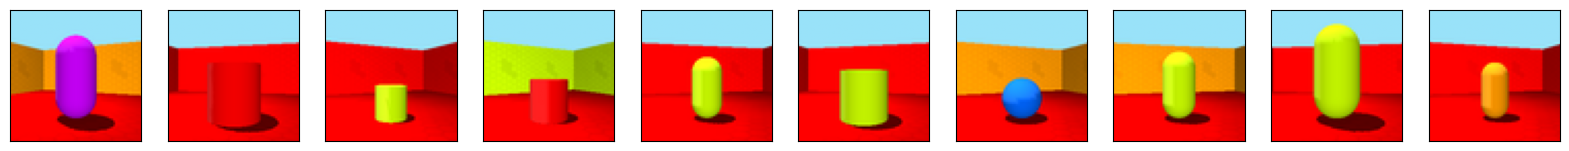

In [18]:
tmp = train_ds.as_numpy_iterator()
imgs = tmp.next()[0]
plt.figure(figsize=(20, 4))
n=10
for i in range(n):
  img = imgs[i]
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


# Defining and training autoencoder models

some snippets are from [here](https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising)

In [20]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model



## First autoencoder: very large latent space

Every original images can be described by only 6 independent ground truth parameters. In this section the model has 200 latent parameters.

In [21]:
class Autoencoder(Model):
  def __init__(self, latent_dim = 198):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64, 3)),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu')])

    expected_shape = self.encoder.layers[-3].compute_output_shape((64, 64, 3))
    self.decoder = tf.keras.Sequential([
      layers.Input(shape=(latent_dim,)),
      layers.Dense(np.prod(expected_shape[:])),
      layers.Reshape(target_shape=expected_shape[:]),
      layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'),
      layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=4)])


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded

autoencoder = Autoencoder(latent_dim = 200)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())




In [22]:
autoencoder.fit(train_ds,
                epochs=10,
                shuffle=True,
                validation_data=val_ds)




Epoch 1/10
219/219 [==============================] - 24s 48ms/step - loss: 0.0608 - val_loss: 0.0425
Epoch 2/10
219/219 [==============================] - 8s 35ms/step - loss: 0.0402 - val_loss: 0.0322
Epoch 3/10
219/219 [==============================] - 9s 39ms/step - loss: 0.0162 - val_loss: 0.0077
Epoch 4/10
219/219 [==============================] - 9s 39ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 5/10
219/219 [==============================] - 8s 37ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 6/10
219/219 [==============================] - 9s 39ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/10
219/219 [==============================] - 9s 39ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/10
219/219 [==============================] - 9s 41ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/10
219/219 [==============================] - 8s 38ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/10
219/219 [==============================] - 9s 40ms/step - loss: 8.9250e-04 - v

In [23]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()
autoencoder_n_latent = autoencoder.encoder.layers[-1].get_weights()[0].shape[1]

print(f'Number of latent parameters: {autoencoder_n_latent}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 200)               409800    
                                                                 
Total params: 415832 (1.59 MB)
Trainable params: 415832 (1.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1

as one can see, the **latent space here is large** (200 parameters).

The total number of pixels in a trainng image is 64x64x3 = 12288.

In [24]:
def compare_reconstruction(model, n=10, use_val_ds = True):
  if use_val_ds:
    tmp = val_ds.as_numpy_iterator()
  else:
    tmp = train_ds.as_numpy_iterator()


  one_batch = tmp.next()[0] #[0] means the input data (image). [1] is the same thing (it is a label y)
  batch_in = one_batch
  batch_out = model(one_batch)

  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(batch_in[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(batch_out[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()


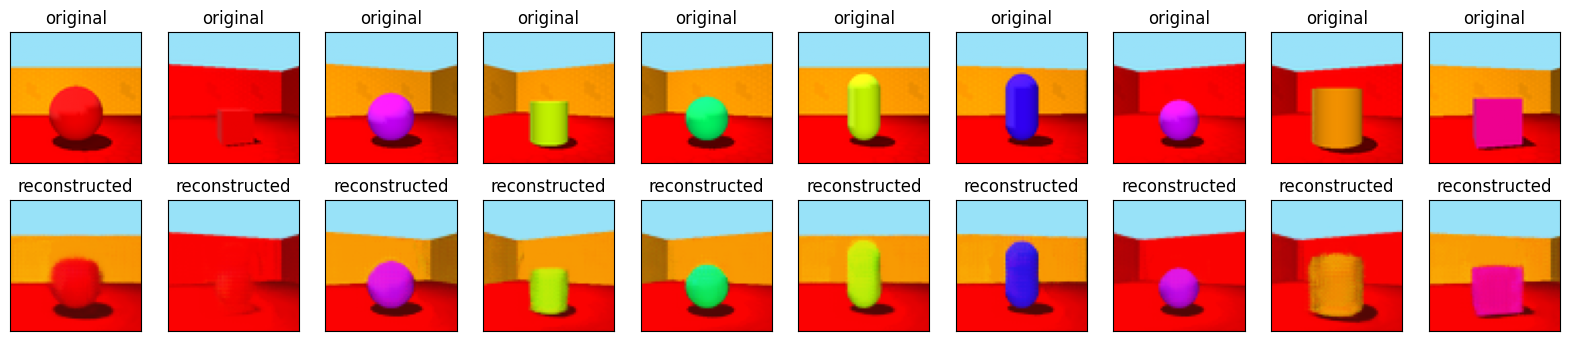

In [25]:
compare_reconstruction(autoencoder)


Even though the compression is by a factor of $\sim$ 60, the reconstruction is a bit blurry... Definetely not optimal solution.

May be we can do better if we trained model longer. JPEG compression if usually by a factor of 60 and does much better job.

## Second autoencoder: smaller latent space

Here we have 20-dimensional latent space

In [26]:

autoencoder2 = Autoencoder(latent_dim = 20)
autoencoder2.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [27]:
autoencoder2.fit(train_ds,
                epochs=20,
                shuffle=True,
                validation_data=val_ds)



Epoch 1/20
219/219 [==============================] - 11s 39ms/step - loss: 0.0848 - val_loss: 0.0491
Epoch 2/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0408 - val_loss: 0.0321
Epoch 3/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0286 - val_loss: 0.0271
Epoch 4/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0228 - val_loss: 0.0169
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0129 - val_loss: 0.0095
Epoch 6/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 7/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 8/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0024 - val_l

In [28]:
autoencoder2.encoder.summary()
autoencoder2.decoder.summary()
autoencoder2_n_latent = autoencoder2.encoder.layers[-1].get_weights()[0].shape[1]

print(f'Number of latent parameters: {autoencoder2_n_latent}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                40980     
                                                                 
Total params: 47012 (183.64 KB)
Trainable params: 47012 (183.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequenti

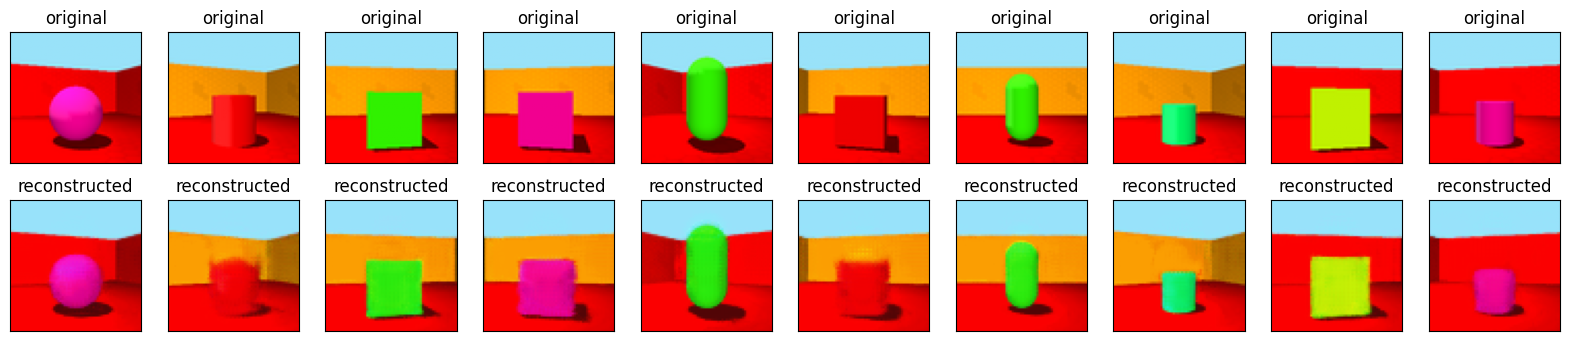

In [29]:
compare_reconstruction(autoencoder2)


## Third autoencoder: Can we go to 6 parameters?

THe original dataset is generated from 6-parameters model.

In [30]:

autoencoder3 = Autoencoder(latent_dim = 6)
autoencoder3.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [31]:
autoencoder3.fit(train_ds,
                epochs=30,
                shuffle=True,
                validation_data=val_ds)



Epoch 1/30
219/219 [==============================] - 11s 39ms/step - loss: 0.0732 - val_loss: 0.0363
Epoch 2/30
219/219 [==============================] - 9s 40ms/step - loss: 0.0239 - val_loss: 0.0178
Epoch 3/30
219/219 [==============================] - 8s 38ms/step - loss: 0.0149 - val_loss: 0.0120
Epoch 4/30
219/219 [==============================] - 8s 38ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 5/30
219/219 [==============================] - 8s 37ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 6/30
219/219 [==============================] - 8s 37ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 7/30
219/219 [==============================] - 8s 37ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 8/30
219/219 [==============================] - 8s 37ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/30
219/219 [==============================] - 8s 37ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/30
219/219 [==============================] - 8s 36ms/step - loss: 0.0047 - val_l

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 32)          4640      
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 18326 (71.59 KB)
Trainable params: 18326 (71.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential

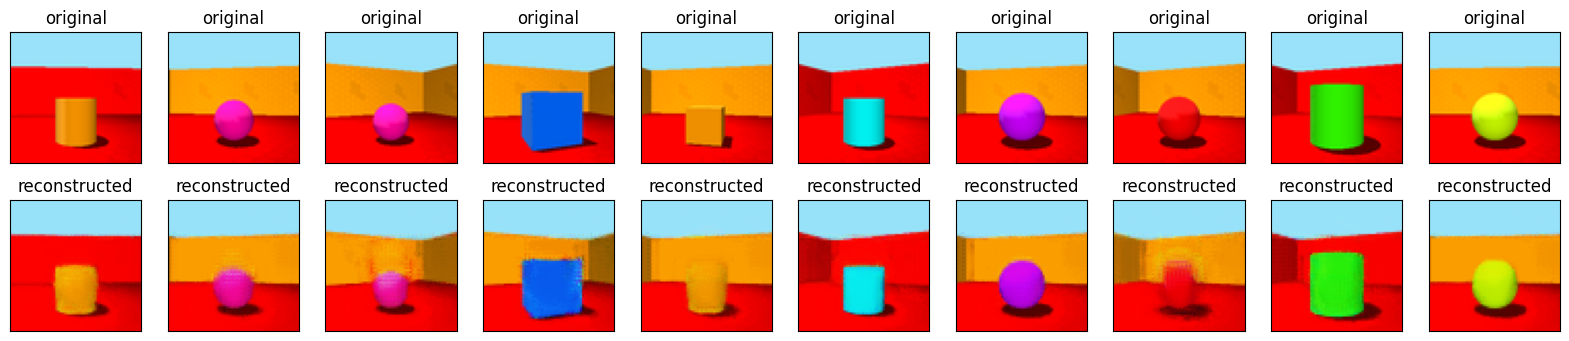

In [32]:
autoencoder3.encoder.summary()
autoencoder3.decoder.summary()
autoencoder3_n_latent = autoencoder3.encoder.layers[-1].get_weights()[0].shape[1]

print(f'Number of latent parameters: {autoencoder3_n_latent}')

compare_reconstruction(autoencoder3)


remarkable reconstruction of the image from only six parameters (compression by a factor of 2048).

Loss function stalled a bit in the last few epochs, may be we could perform parameter tuning and continue training with new hyperparameters to decrease the loss.

Are we overfitting? Lets compare reconstruction for test data

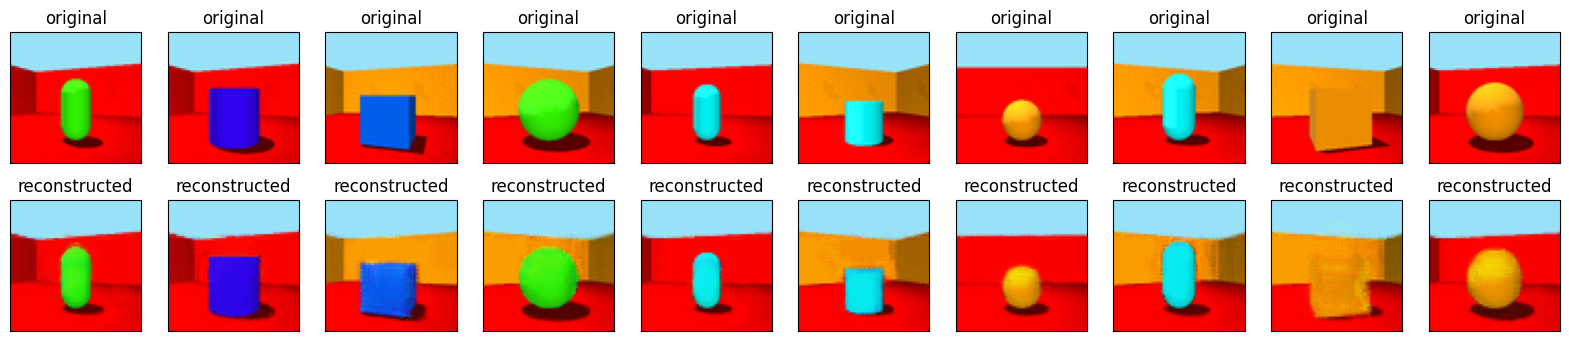

In [33]:
compare_reconstruction(autoencoder3, use_val_ds = False)

does not seem so. Loss functions are very close for train and validation data.

## 6 numbers reconstruct the image? Lets plot a few examples and their latent representation

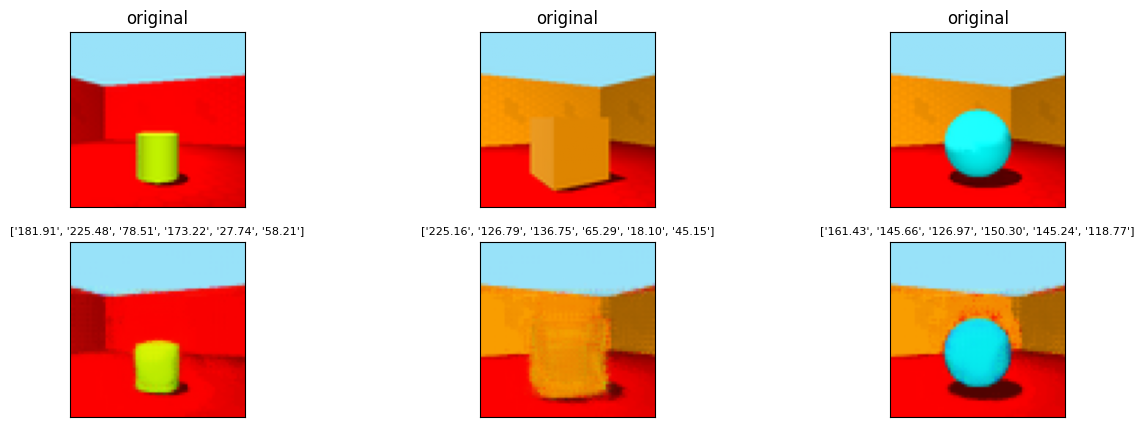

In [34]:
def find_latent_repr_space_for_example(model, n=3):

  tmp = val_ds.as_numpy_iterator()

  one_batch = tmp.next()[0]
  batch_in = one_batch
  #batch_out = model(one_batch)
  batch_encoded = model.encoder(one_batch)
  batch_decoded = model.decoder(batch_encoded)


  plt.figure(figsize=(15, 5))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(batch_in[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(batch_decoded[i])
    str_tmp = batch_encoded[i]
    str_tmp = [f'{s:.2f}' for s in str_tmp]
    plt.title(str_tmp, fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

find_latent_repr_space_for_example(autoencoder3)


In one of runs, that for some reason **one latent parameter was always  0**, I don't know why.

May be its because I used the first few tens of thousand of ordered training data example out of all 480k dataset (all floors are red?).

Interesing to explore later. It does not seem to affect output at all (tried a bunch of values).

# Visualise the effect of latent variables on the reconstruction

since this autoencoder is not able to map the images into a particular probability distribution in latent space, we expect gibberish output

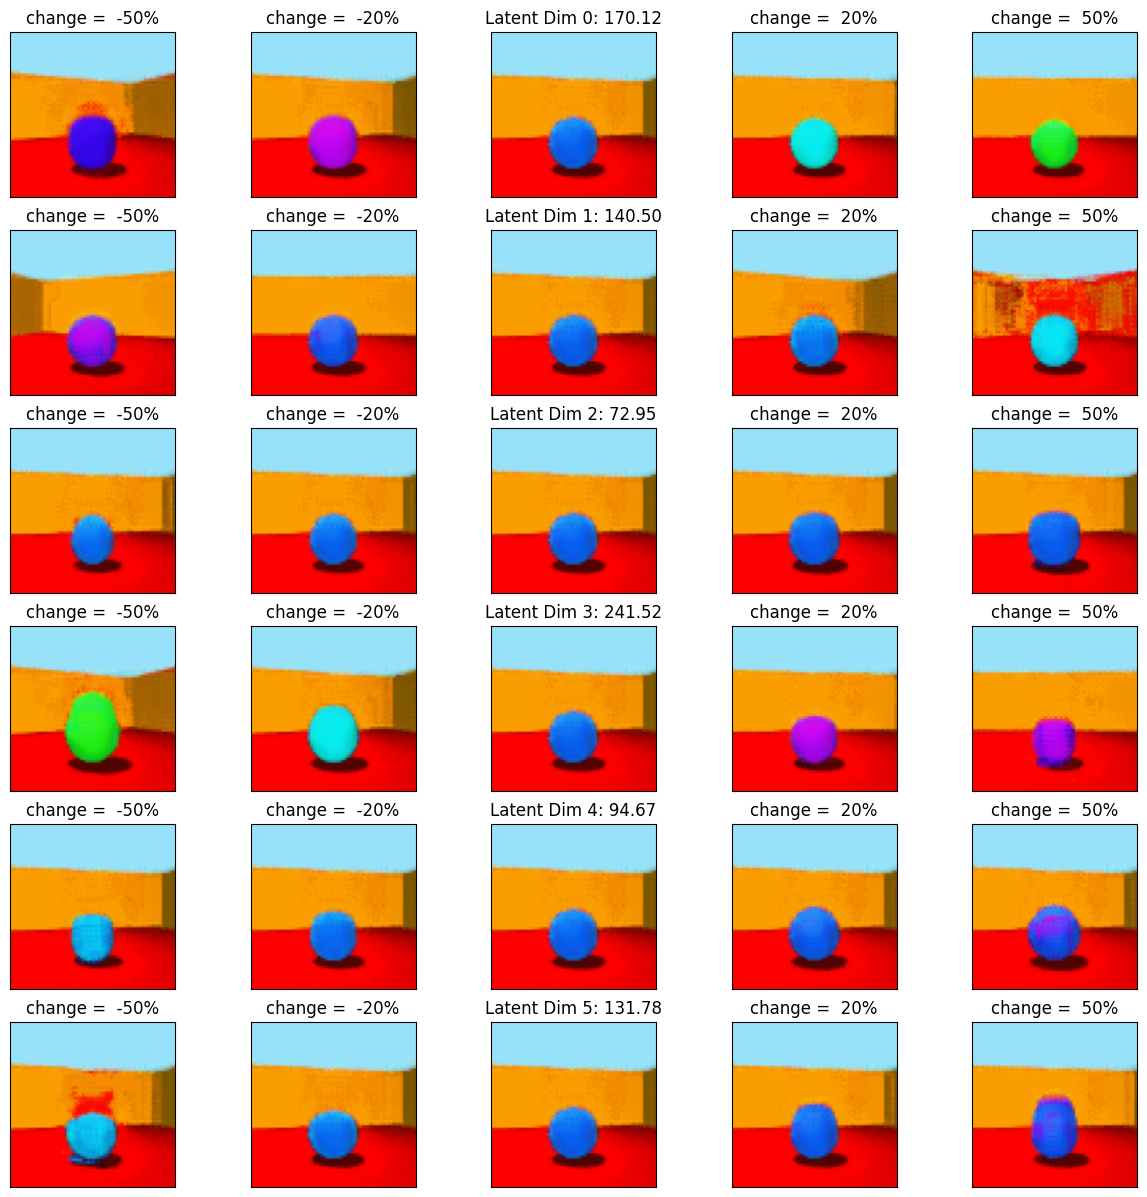

In [36]:

def visualize_latent_variable_effect(model, image_example, latent_dim, n_samples=5, percentage_changes=[-0.5, -0.2, 0, 0.2, 0.5]):
    #this function was written with ChatGPT
    """
    Visualize the effect of changing each latent variable by specified percentage changes for a single image example.

    Parameters:
    - model: The autoencoder model.
    - image_example: A single image example (e.g., one element from your dataset).
    - latent_dim: The number of latent dimensions in your autoencoder.
    - n_samples: The number of different values to sample for each latent variable.
    - percentage_changes: A list of percentage changes to apply to each latent variable.
    """

    # Encode the image example to get the latent representation
    latent_representation = model.encoder(image_example)

    # Create a grid of plots to visualize the effect of changing each latent variable
    plt.figure(figsize=(15, 15))
    for i in range(latent_dim):
        for change_percentage in percentage_changes:
            # Create a new variable tensor with the same values as the original latent representation
            modified_latent = tf.Variable(latent_representation)

            # Calculate the new value for the current latent variable
            original_value = modified_latent[0, i]

            #if original_value==0:
            #  original_value = original_value + 20

            change_value = original_value * change_percentage
            new_value = original_value + change_value

            # Modify the current latent variable
            modified_latent[0, i].assign(new_value)

            # Decode the modified latent representation to get the corresponding image
            modified_image = model.decoder(modified_latent)

            # Plot the modified image
            ax = plt.subplot(latent_dim, len(percentage_changes), i * len(percentage_changes) + percentage_changes.index(change_percentage) + 1)
            plt.imshow(modified_image[0])  # Assuming you have a batch size of 1
            if change_percentage==0:
              plt.title(f"Latent Dim {i}: {original_value:.2f}")
            else:
              plt.title(f"change =  {change_percentage*100:.0f}%")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

tmp = train_ds.as_numpy_iterator()
one_batch = tmp.next()[0] #[0] means the input data (image). [1] is the same thing (it is a label y)

# Usage example:
# Provide your autoencoder model, an image example, the number of latent dimensions, and other parameters.
visualize_latent_variable_effect(autoencoder3, one_batch[0:1], latent_dim=6, n_samples=5)


Definitely gibberish.

We will try **Variational Autoencoder (VAE)** in the next notebook.

It should be able to generate reaslistic images for different latent vectors.